In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

df_train = pd.read_csv('/home/zan/Desktop/dl_autoencoder/docs/autoencoder/deceptive_opinion_autoencoder/deceptive_training.csv')
df_test = pd.read_csv('/home/zan/Desktop/dl_autoencoder/docs/autoencoder/deceptive_opinion_autoencoder/deceptive_testing.csv')

In [2]:
### Remplazar los truthful con 0 y deceptive con 1 en la columna deceptive
df_train = df_train.replace({'deceptive': {'truthful': 0, 'deceptive': 1}})
df_test = df_test.replace({'deceptive': {'truthful': 0, 'deceptive': 1}})

In [3]:
"""
## Split train -- validation
split = int(0.8 * len(df_train))
validation_set = df_train[split:]
df_train = df_train[:split]
"""

'\n## Split train -- validation\nsplit = int(0.8 * len(df_train))\nvalidation_set = df_train[split:]\ndf_train = df_train[:split]\n'

In [4]:
train_dec_a = df_train.iloc[:, 0]
#validation_dec_a = validation_set.iloc[:, 0]
test_dec_a = df_test.iloc[:, 0]

train_dec_a.columns = ['train_dec_a']
#validation_dec_a.columns = ['validation_dec_a']
test_dec_a.columns = ['test_dec_a']

In [5]:

x_train = ()
y_train = ()

for index, row in df_train.iterrows():
    res = list(map(float, row['text'].split(' ')))
    res = np.asarray(res, dtype=np.float32)
    x_train = x_train + (res,)
    y_train = y_train + (row['deceptive'],)

"""
x_validation = ()
y_validation = ()

for index, row in validation_set.iterrows():
    res = list(map(float, row['text'].split(' ')))
    res = np.asarray(res, dtype=np.float32)
    x_validation = x_validation + (res,)
    y_validation = y_validation + (row['deceptive'],)
"""
x_test = ()
y_test = ()

for index, row in df_test.iterrows():
    res = list(map(float, row['text'].split(' ')))
    res = np.asarray(res, dtype=np.float32)
    x_test = x_test + (res,)
    y_test = y_test + (row['deceptive'],)


In [6]:
import numpy as np
x_train, y_train = np.asarray(x_train), np.asarray(y_train)
#x_validation, y_validation = np.asarray(x_validation), np.asarray(y_validation)
x_test, y_test = np.asarray(x_test), np.asarray(y_test)

x_train = x_train.astype('float32')
#x_validation = x_validation.astype('float32')
x_test = x_test.astype('float32')

In [8]:
#x_validation.shape

In [7]:
# reshape inputs for LSTM [samples, timesteps, features]
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1]) # X_train 
print("Training data shape:", x_train.shape)
#x_validation = x_validation.reshape(x_validation.shape[0], 1, x_validation.shape[1]) # X_train 
#print("Validation data shape:", x_validation.shape)
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])     # X_test 
print("Test data shape:", x_test.shape)

Training data shape: (600, 1, 300)
Test data shape: (200, 1, 300)


## Primer MODELO -- mediante LSTM

In [9]:
## Autoencoder simple 

import keras
from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, LSTM, TimeDistributed, RepeatVector, Dropout
from keras.models import Model
from keras.utils import plot_model
from keras import backend as BE
from keras import regularizers

import numpy as np
import matplotlib.pyplot as plt

def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(32, activation='relu', return_sequences=True,  
              kernel_regularizer=regularizers.l1(0.01))(inputs)
    L2 = Dropout(0.2)(L1)   
    L3 = LSTM(4, activation='relu', return_sequences=False, kernel_regularizer=regularizers.l1(0.01))(L2)
    L4 = RepeatVector(X.shape[1])(L3)
    L5 = LSTM(4, activation='relu', return_sequences=True)(L4)
    L6 = LSTM(32, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l1(0.01), activity_regularizer=regularizers.l2(0.01))(L5) 
    output = TimeDistributed(Dense(X.shape[2]))(L6)    
    model = Model(inputs=inputs, outputs=output)
    return model


## LSTM extendido

In [10]:
import keras
from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, LSTM, TimeDistributed, RepeatVector, Dropout
from keras.models import Model
from keras.utils import plot_model
from keras import backend as BE
from keras import regularizers

import numpy as np
import matplotlib.pyplot as plt


def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(128, activation='relu', return_sequences=True,  
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(32, activation='relu', return_sequences=True)(L1)
    L3 = LSTM(4, activation='relu', return_sequences=False)(L2)
    L4 = RepeatVector(X.shape[1])(L3)
    L5 = LSTM(4, activation='relu', return_sequences=True)(L4)
    L6 = LSTM(32, activation='relu', return_sequences=True)(L5)
    L7 = LSTM(128, activation='relu', return_sequences=True)(L6)
    output = TimeDistributed(Dense(X.shape[2]))(L7)    
    model = Model(inputs=inputs, outputs=output)
    return model


## Modelo Vanilla LSTM

In [7]:
import keras
from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, LSTM, TimeDistributed, RepeatVector, Dropout
from keras.models import Model
from keras.utils import plot_model
from keras import backend as BE
from keras import regularizers

import numpy as np
import matplotlib.pyplot as plt
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu',  
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    output = (Dense(X.shape[2])) (L1)    
    model = Model(inputs=inputs, outputs=output)
    return model

## Modelo LSTM -- utilizando el Keras Tuner

In [21]:
## Aparte del modelo vamos a definir los hiperparametros construyendo el hypermodelo
## Vamos a utilizar o bien una funccion builder o utilizar una subclase HyperModel usando la Keras Tuner 

import keras
from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, LSTM, TimeDistributed, RepeatVector, Dropout
from tensorflow.keras import models, layers
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras import backend as BE
from keras import regularizers
import kerastuner as kt
from kerastuner import HyperModel
from kerastuner import Hyperband
from kerastuner import BayesianOptimization
from kerastuner.tuners import RandomSearch

import numpy as np
import matplotlib.pyplot as plt


class RegressionHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    def build(self, hp):
        model = Sequential()
        model.add(
            layers.LSTM(300,
                #units=hp.Int('units', 8, 64, 4, default=8),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                return_sequences=True,
                input_shape=input_shape
            )
        )
        """
        for i in range(hp.Int('num_layers', 1, 10)):
            model.add(layers.Dense(units=hp.Int('lay_' + str(i),
                                                min_value=16,
                                                max_value=256,
                                                step=16),
                                    activation=hp.Choice(
                                        'dense_activation',
                                        values=['relu', 'tanh', 'sigmoid'],
                                        default='relu')))
        """
        L1=model.add(
            layers.LSTM(
                units=hp.Int('units_2', min_value=16, max_value=256, step=16), # 'units_2', 16, 32, 64, default=32),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                    kernel_regularizer=regularizers.l2(hp.Choice('regularizers.l2', values=[0.00, 0.01, 0.05, 0.1])), # Valorarlo... 
                return_sequences=True,
                input_shape=input_shape
            )
        ) 
        
        L2=model.add(
            layers.LSTM(
                units=hp.Int('units_3', min_value=2, max_value=32, step=2),              #'units_3', 2, 4, 8, default=4
                activation=hp.Choice( 
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                return_sequences=True,
                input_shape=input_shape
            )
        )  
        
        
        L3=model.add(
            layers.LSTM(
                units=hp.Int('units_4', min_value=2, max_value=32, step=2),              #'units_3', 2, 4, 8, default=4
                activation=hp.Choice( 
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                return_sequences=True,
                input_shape=input_shape
            )
        ) 
        
        L4=model.add(
            layers.LSTM(
                units=hp.Int('units_5', min_value=16, max_value=256, step=16),        #'units_4', 16, 32, 64, default=32
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                return_sequences=True,
                input_shape=input_shape
            )
        )
        model.add(
            layers.Dropout(
                hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.1,
                    default=0.005,
                    step=0.01)
            )
        )
        
        model.add(layers.Dense(300))
        optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop','nadam', 'adadelta',
                                            'adagrad', 'adamax','ftrl'])
        model.compile(
            optimizer=optimizer,loss='mse',metrics=['mse']
        )
        
        return model

In [22]:
input_shape = (x_train.shape[1],x_train.shape[2],)
hypermodel = RegressionHyperModel(input_shape)

## Random Search

In [23]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=10,
            max_trials= 1,
            project_name='opiniondetection',
            directory='/home/zan/Desktop/dl_autoencoder/docs/autoencoder/deceptive_opinion_autoencoder/',
            overwrite=True,
            executions_per_trial=2)

In [24]:
tuner_rs.search(x_train, x_train, epochs=20, validation_split = 0.2, verbose=0)

INFO:tensorflow:Oracle triggered exit


In [25]:
tuner_rs.search_space_summary()

Search space summary
Default search space size: 14
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': None}
lay_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
regularizers.l2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.01, 0.05, 0.1], 'ordered': True}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 32, 'step': 2, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 32, 'step': 2, 'sampling': None}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
dropout (Float)
{'default': 0.005, 

In [26]:
tuner_rs.results_summary()

Results summary
Results in /home/zan/Desktop/dl_autoencoder/docs/autoencoder/deceptive_opinion_autoencoder/opiniondetection
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
dense_activation: sigmoid
num_layers: 5
lay_0: 128
units_2: 80
regularizers.l2: 0.0
units_3: 30
units_4: 12
units_5: 144
dropout: 0.02
optimizer: adam
lay_1: 16
lay_2: 16
lay_3: 16
lay_4: 16
Score: 0.23762203007936478


In [33]:
#model = tuner_rs.get_best_models(num_models=1)[0]
#loss, mse = model.evaluate(x_test, x_test)

In [27]:
model = tuner_rs.get_best_models(num_models=1)[0]
loss, mse = model.evaluate(x_train, x_train)

19/19 [==============================] - 0s 10ms/step - loss: 0.2340 - mse: 0.2340


In [28]:
tuner_rs.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'dense_activation': 'sigmoid',
 'num_layers': 5,
 'lay_0': 128,
 'units_2': 80,
 'regularizers.l2': 0.0,
 'units_3': 30,
 'units_4': 12,
 'units_5': 144,
 'dropout': 0.02,
 'optimizer': 'adam',
 'lay_1': 16,
 'lay_2': 16,
 'lay_3': 16,
 'lay_4': 16}

In [29]:
model = tuner_rs.get_best_models(num_models=1)[0]
mse_rs = model.evaluate(x_test, x_test)[1]
print('Random search MSE: ', mse_rs)

7/7 [==============================] - 0s 20ms/step - loss: 0.2326 - mse: 0.2326
Random search MSE:  0.23255543410778046


## Hyperband

In [28]:
tuner_hb = Hyperband(
            hypermodel,
            max_epochs= 20,
            objective='mse',
            seed=100,
            overwrite=True,
            executions_per_trial=4
        )

In [29]:
tuner_hb.search(x_train, x_train, epochs= 10, validation_split = 0.2, verbose=0) ## Probar las trazas con verbose a 1
model = tuner_hb.get_best_models(num_models=1)[0]
model.evaluate(x_train, x_train)

KeyboardInterrupt: 

In [ ]:
tuner_hb.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

In [ ]:
model = tuner_hb.get_best_models(num_models=1)[0]
mse_hb = best_model.evaluate(x_train, x_train)[1]
print('Hyperband Optimization MSE: ', mse_hb)

## Bayesian Optimization

In [11]:
tuner_bo = BayesianOptimization(
            hypermodel,
            objective='mse',
            max_trials=2,
            seed=10,
            overwrite=True,
            executions_per_trial=4
        )

In [12]:
tuner_bo.search(x_train, x_train, epochs=20, validation_split = 0.2, verbose=0) 

INFO:tensorflow:Oracle triggered exit


In [13]:
model = tuner_bo.get_best_models(num_models=1)[0]
model.evaluate(x_train, x_train)

19/19 [==============================] - 0s 10ms/step - loss: 0.0423 - mse: 0.0207


[0.04226936027407646, 0.020726867020130157]

In [14]:
tuner_bo.get_best_models(num_models=1)[0]
tuner_bo.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'dense_activation': 'relu',
 'units_2': 176,
 'regularizers.l2': 0.01,
 'units_3': 6,
 'units_4': 30,
 'units_5': 240,
 'dropout': 0.07,
 'optimizer': 'adamax'}

In [15]:
model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = model.evaluate(x_train, x_train)[1]
print('Bayesian Optimization MSE: ', mse_bo)

19/19 [==============================] - 0s 11ms/step - loss: 0.0423 - mse: 0.0207
Bayesian Optimization MSE:  0.020726867020130157


## Results for the different keras methods

In [42]:
tuner_rs.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'dense_activation': 'sigmoid',
 'units_2': 128,
 'regularizers.l2': 0.1,
 'units_3': 10,
 'units_4': 6,
 'units_5': 240,
 'dropout': 0.04,
 'optimizer': 'adamax'}

In [43]:
tuner_rs.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 300)            721200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 128)            219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 10)             5560      
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 6)              408       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 240)            237120    
_________________________________________________________________
dropout (Dropout)            (None, 1, 240)            0         
_________________________________________________________________
dense (Dense)                (None, 1, 300)            7

In [47]:
tuner_bo.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'dense_activation': 'relu',
 'units_2': 176,
 'regularizers.l2': 0.01,
 'units_3': 6,
 'units_4': 30,
 'units_5': 240,
 'dropout': 0.07,
 'optimizer': 'adamax'}

In [45]:
tuner_bo.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 300)            721200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 176)            335808    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 6)              4392      
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 30)             4440      
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 240)            260160    
_________________________________________________________________
dropout (Dropout)            (None, 1, 240)            0         
_________________________________________________________________
dense (Dense)                (None, 1, 300)            7

## Limite Keras Tuner

In [10]:
# create the autoencoder model
model = autoencoder_model(x_train)
#opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer='adamax', loss='mae', metrics=['mae', 'mse', 'mape', 'msle', 
                                                     'cosine_proximity']) #Error absoluto medio (mae), MeanSquaredError mse
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 300)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 32)             42624     
_________________________________________________________________
dropout (Dropout)            (None, 1, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 592       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 32)            

In [11]:
import time
# collect data across multiple repeats
dtrain = DataFrame()
val = DataFrame()
# fit the model to the data

for i in range(2):
    print("Fit model on training data...")
    start = time.time()
    nb_epochs = 300 
    batch_size = 128
        
    history = model.fit(x_train, x_train, epochs=nb_epochs, batch_size=batch_size, validation_split = 0.2, verbose= 0).history 
    end = time.time()
    dtrain[str(i)] = history['loss']
    val[str(i)] = history['val_loss']
    print("Time to training model: ", end='')
    print(end - start)

Fit model on training data...
Time to training model: 29.51190686225891
Fit model on training data...
Time to training model: 17.458576440811157


In [9]:
### Vanilla

import time
# collect data across multiple repeats
dtrain = DataFrame()
val = DataFrame()
# fit the model to the data

for i in range(1):
    print("Fit model on training data...")
    start = time.time()
    nb_epochs = 100 
    batch_size = 128
    
    history = model.fit(x_train, x_train, epochs=nb_epochs, batch_size=batch_size, validation_split = 0.2, verbose= 0).history 
    end = time.time()
    dtrain[str(i)] = history['loss']
    val[str(i)] = history['val_loss']
    print("Time to training model: ", end='')
    print(end - start)

Fit model on training data...
Time to training model: 47.141523599624634


In [12]:
x_train.shape

(600, 1, 300)

                0           1
count  300.000000  300.000000
mean     1.423580    0.407642
std      3.545772    0.000225
min      0.407621    0.407088
25%      0.408248    0.407477
50%      0.413839    0.407648
75%      0.618438    0.407808
max     24.645885    0.408233


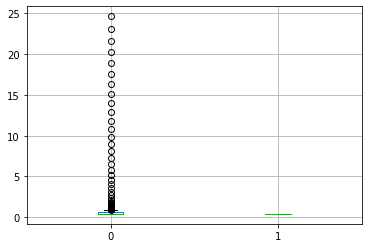

In [13]:
print(dtrain.describe())
dtrain.boxplot()
plt.show()

In [14]:
print("Best MAE on Validation Set =", max(history['val_mae']))

Best MAE on Validation Set = 0.3395041227340698


In [15]:
print("Best MSE on Validation Set =", max(history['val_mse']))

Best MSE on Validation Set = 0.2600303590297699


In [16]:
loss = model.evaluate(x_train, x_train, verbose=0)
print(loss)

[0.4039900004863739, 0.35202527046203613, 0.273085355758667, 91.78803253173828, 0.02272266522049904, 0.9923304319381714]


In [15]:
#loss = model.evaluate(x_test, x_test, verbose=0)
#print(loss)

In [17]:
for name, value in zip(model.metrics_names, loss):
    print(name, value)

loss 0.4039900004863739
mae 0.35202527046203613
mse 0.273085355758667
mape 91.78803253173828
msle 0.02272266522049904
cosine_proximity 0.9923304319381714


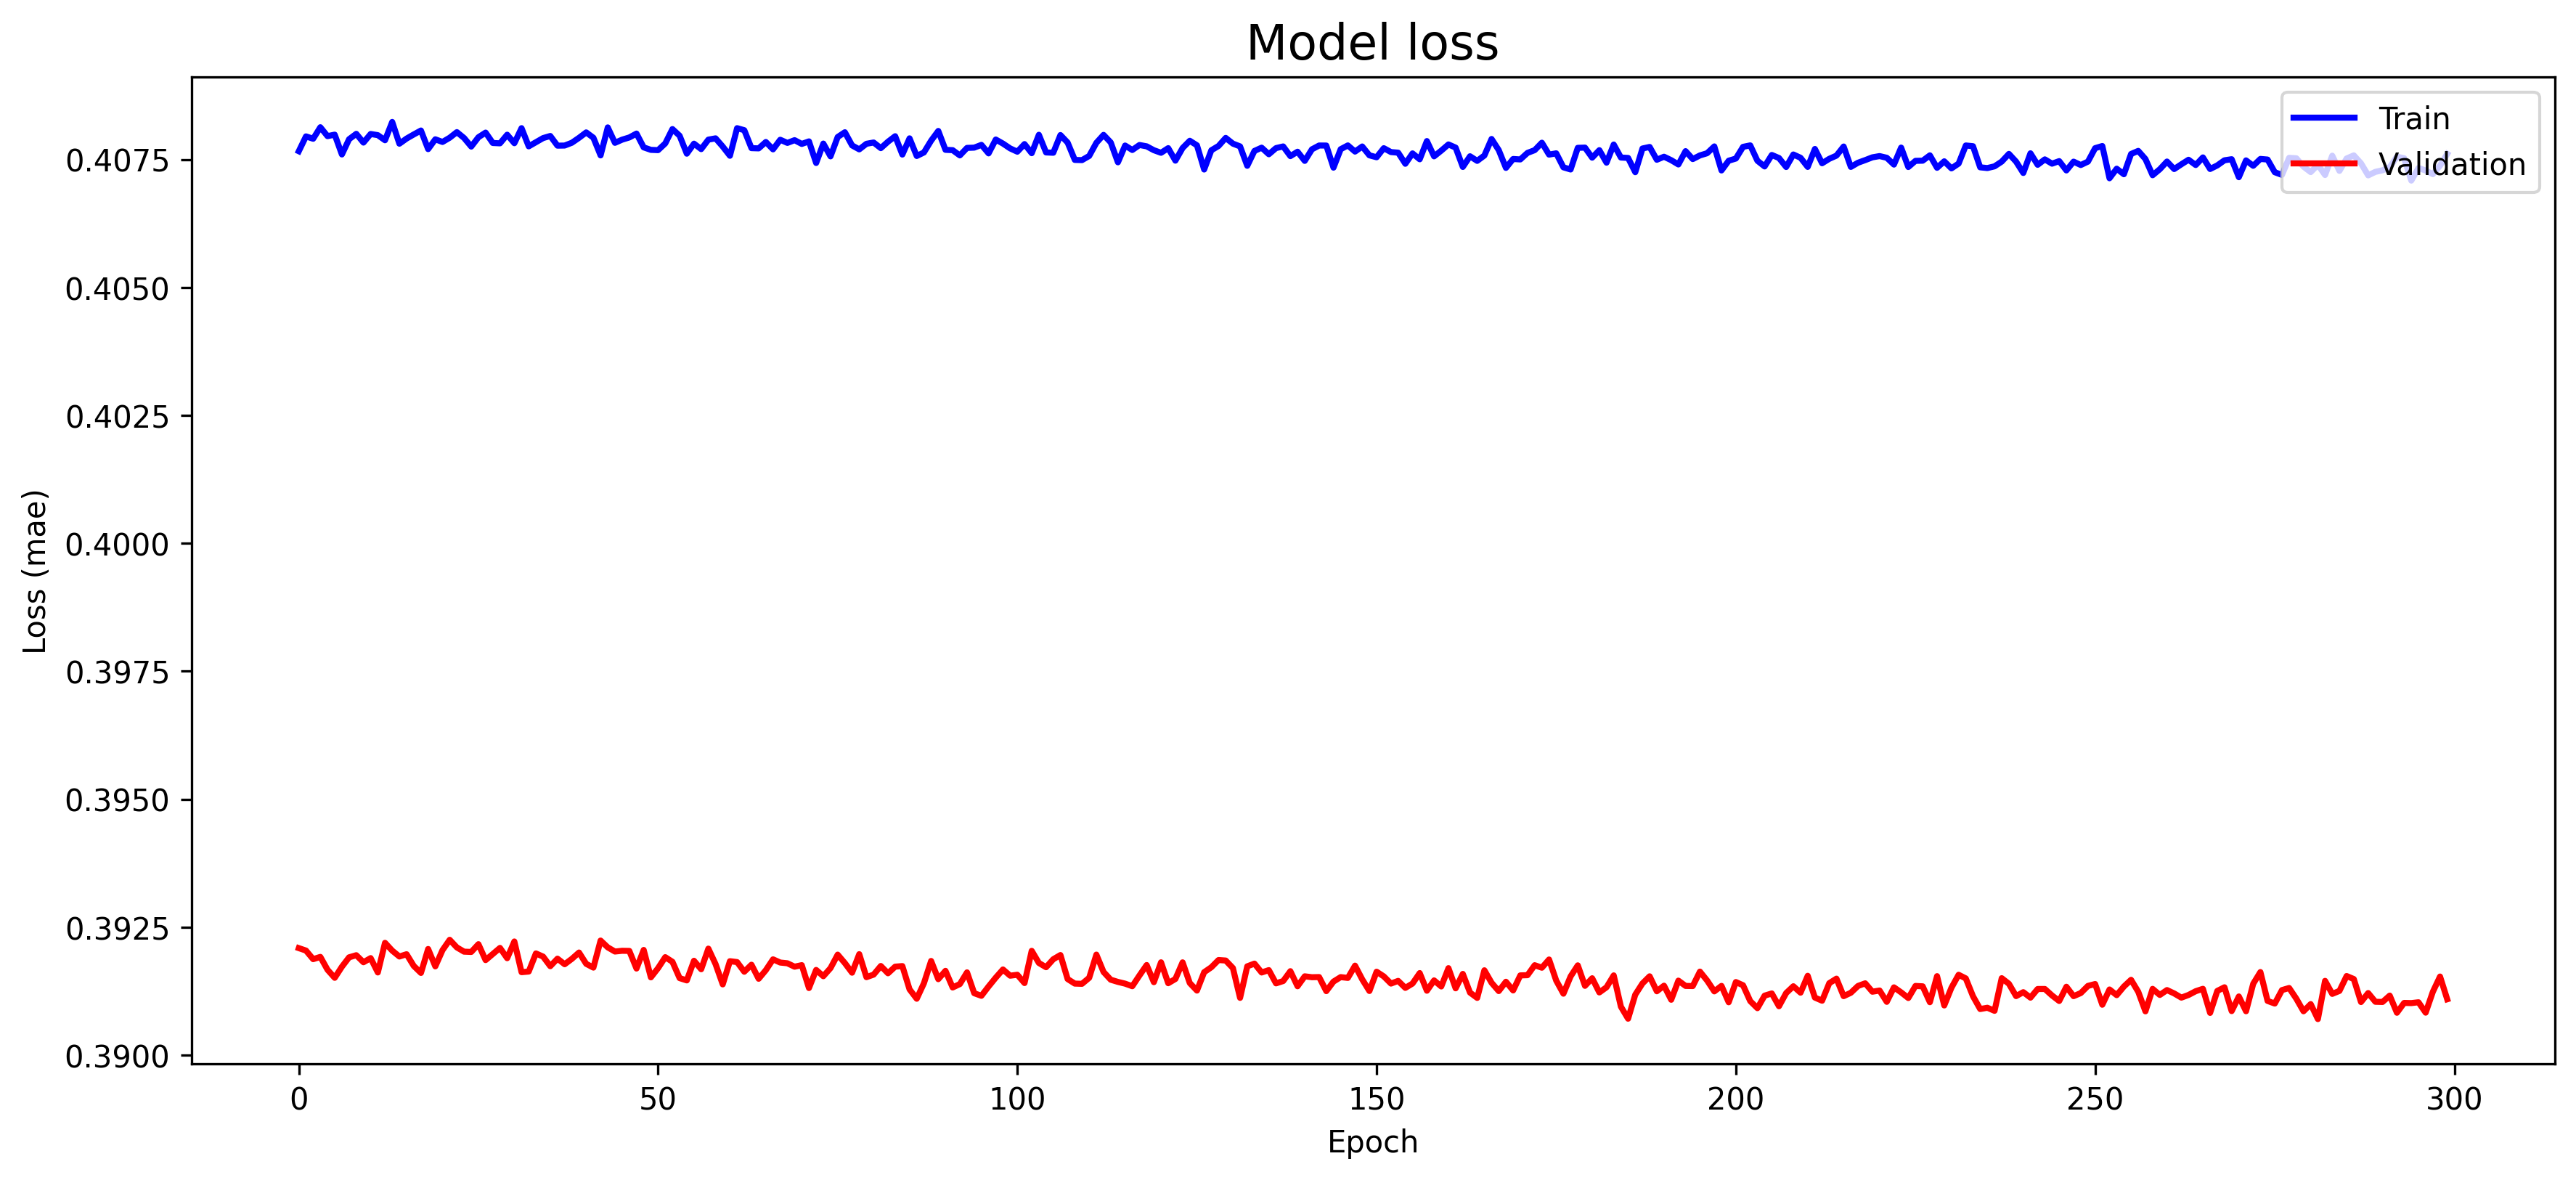

In [18]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

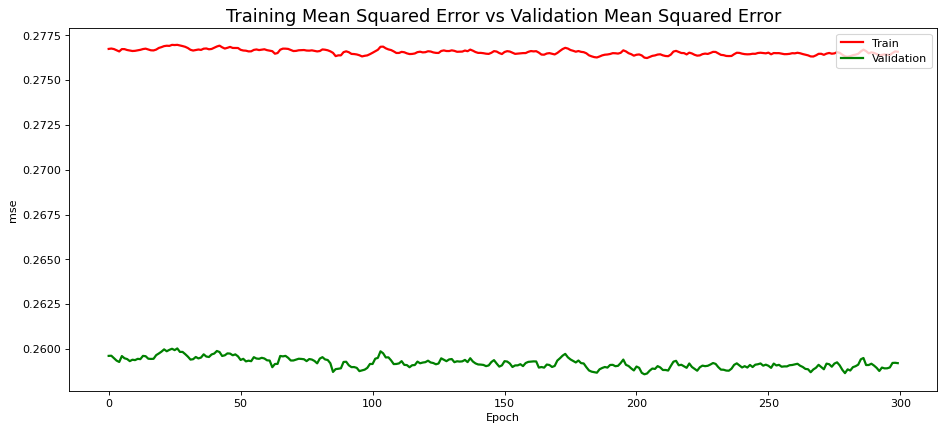

In [19]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['mse'], 'r', label='Train', linewidth=2)
ax.plot(history['val_mse'], 'g', label='Validation', linewidth=2)
ax.set_title('Training Mean Squared Error vs Validation Mean Squared Error', fontsize=16)
ax.set_ylabel('mse')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

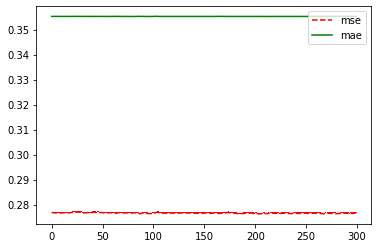

In [20]:
# plot metrics
plt.plot(history['mse'],'r--,', label='mse')
plt.plot(history['mae'],'g', label='mae')
plt.legend(loc='upper right')
plt.show()

## Distributon of Loss Function

In [21]:
XPred = model.predict(x_train)
XPred.shape

(600, 1, 300)

"\nXPred = XPred.reshape(XPred.shape[0] * XPred.shape[2], XPred.shape[1])\nXPred = pd.DataFrame(XPred, columns=['text'])\nXPred.index = df_train.index * 200\n\nscored = pd.DataFrame(index=df_train.index)\nXtrain = x_train.reshape(x_train.shape[0] * x_train.shape[2], x_train.shape[1])\nscored['Loss_mae'] = np.mean(np.abs(XPred-Xtrain), axis = 1)\n\n\nplt.figure(figsize=(16,9), dpi= 300)\nplt.title('Loss Distribution', fontsize=16)\nsns.distplot(scored['Loss_mae'], bins = 40, kde= True, color = 'blue')\nplt.xlim([0.001,0.004])\n"

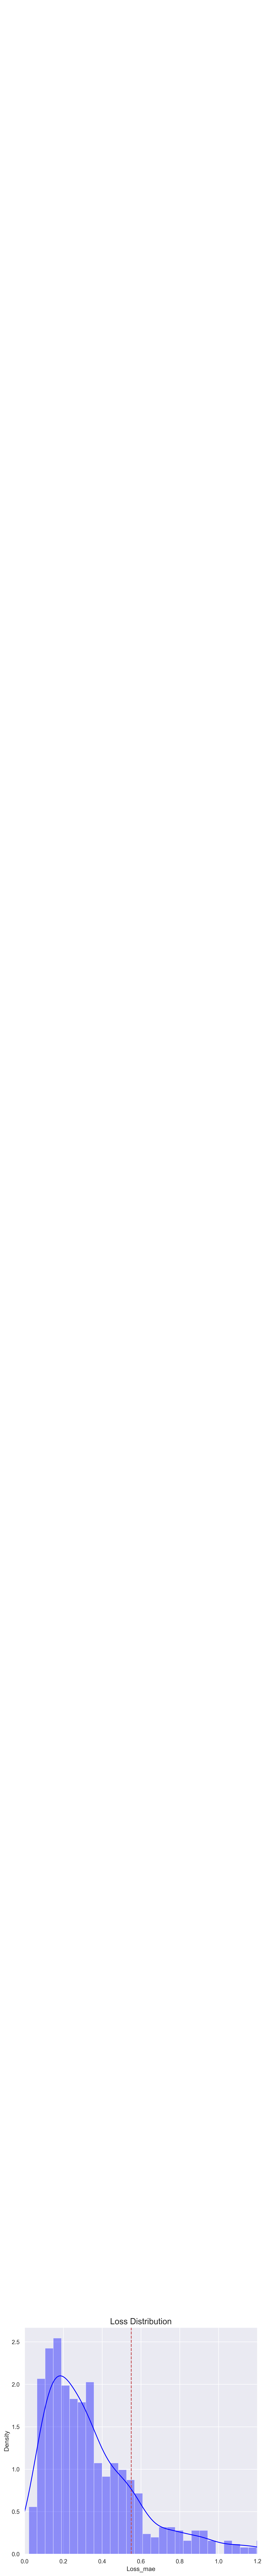

In [22]:
import seaborn as sns
sns.set(color_codes=True)

# plot the loss distribution of the training set
XPred = model.predict(x_train)
XPred = XPred.reshape(XPred.shape[0], XPred.shape[2])
#XPred = XPred.reshape(XPred.shape[0], XPred.shape[1])
XPred = pd.DataFrame(XPred)

XTrain = x_train.reshape(x_train.shape[0], x_train.shape[2])
scored = pd.DataFrame(index=XPred.index)
scored['Loss_mae'] = np.mean(np.abs(XPred-XTrain), axis = 1)

plt.figure(figsize=(8,8), dpi= 300)
plt.title('Loss Distribution', fontsize=16)
plt.axvline(0.55, ls='--', color='r')
plt.annotate('Threshold = 0.55',
            xy=(0.55, 30), xycoords='data', fontsize=10,
            horizontalalignment='center', verticalalignment='bottom')
sns.distplot(scored['Loss_mae'], color = 'blue', bins = 40, kde=True)
plt.xlim([0.00,1.2])
"""
XPred = XPred.reshape(XPred.shape[0] * XPred.shape[2], XPred.shape[1])
XPred = pd.DataFrame(XPred, columns=['text'])
XPred.index = df_train.index * 200

scored = pd.DataFrame(index=df_train.index)
Xtrain = x_train.reshape(x_train.shape[0] * x_train.shape[2], x_train.shape[1])
scored['Loss_mae'] = np.mean(np.abs(XPred-Xtrain), axis = 1)


plt.figure(figsize=(16,9), dpi= 300)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 40, kde= True, color = 'blue')
plt.xlim([0.001,0.004])
"""

In [23]:
# calculate the loss on the test set
XPred = model.predict(x_test)
XPred = XPred.reshape(XPred.shape[0], XPred.shape[2])
#XPred = XPred.reshape(XPred.shape[0], XPred.shape[1])
XPred = pd.DataFrame(XPred)

scored = pd.DataFrame(index=XPred.index)
Xtest = x_test.reshape(x_test.shape[0], x_test.shape[2])

scored['Loss_mae'] = np.mean(np.abs(XPred-Xtest), axis = 1)
scored['Threshold'] = 0.55
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
0,0.594684,0.55,True
1,0.199420,0.55,False
2,0.049063,0.55,False
3,0.329901,0.55,False
4,0.507551,0.55,False


In [24]:
scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Loss_mae   200 non-null    float32
 1   Threshold  200 non-null    float64
 2   Anomaly    200 non-null    bool   
dtypes: bool(1), float32(1), float64(1)
memory usage: 2.7 KB


In [25]:
data_filter = scored[scored['Anomaly'] == True]
data_filter.head(100)

,Loss_mae,Threshold,Anomaly
0,0.594684,0.55,True
7,0.581468,0.55,True
13,0.635031,0.55,True
19,0.604140,0.55,True
21,0.571885,0.55,True
25,0.733638,0.55,True
29,0.818034,0.55,True
32,0.596480,0.55,True
34,0.657988,0.55,True
36,0.563501,0.55,True


In [26]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(x_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
#X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[1])
X_pred_train = pd.DataFrame(X_pred_train)

scored_train = pd.DataFrame(index=X_pred_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-XTrain), axis = 1)
scored_train['Threshold'] = 0.55
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

<AxesSubplot:>

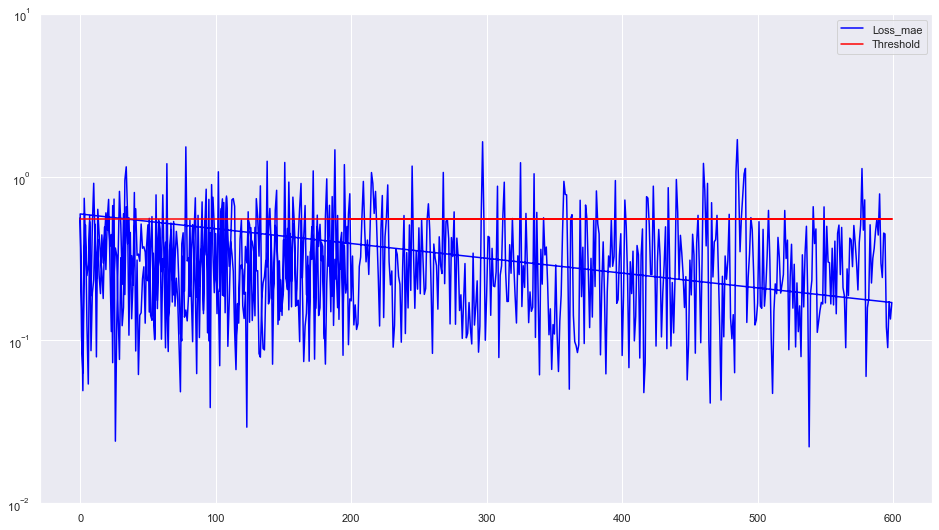

In [27]:
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e1], color=['blue','red'])

## Determinación de threshold con (max)

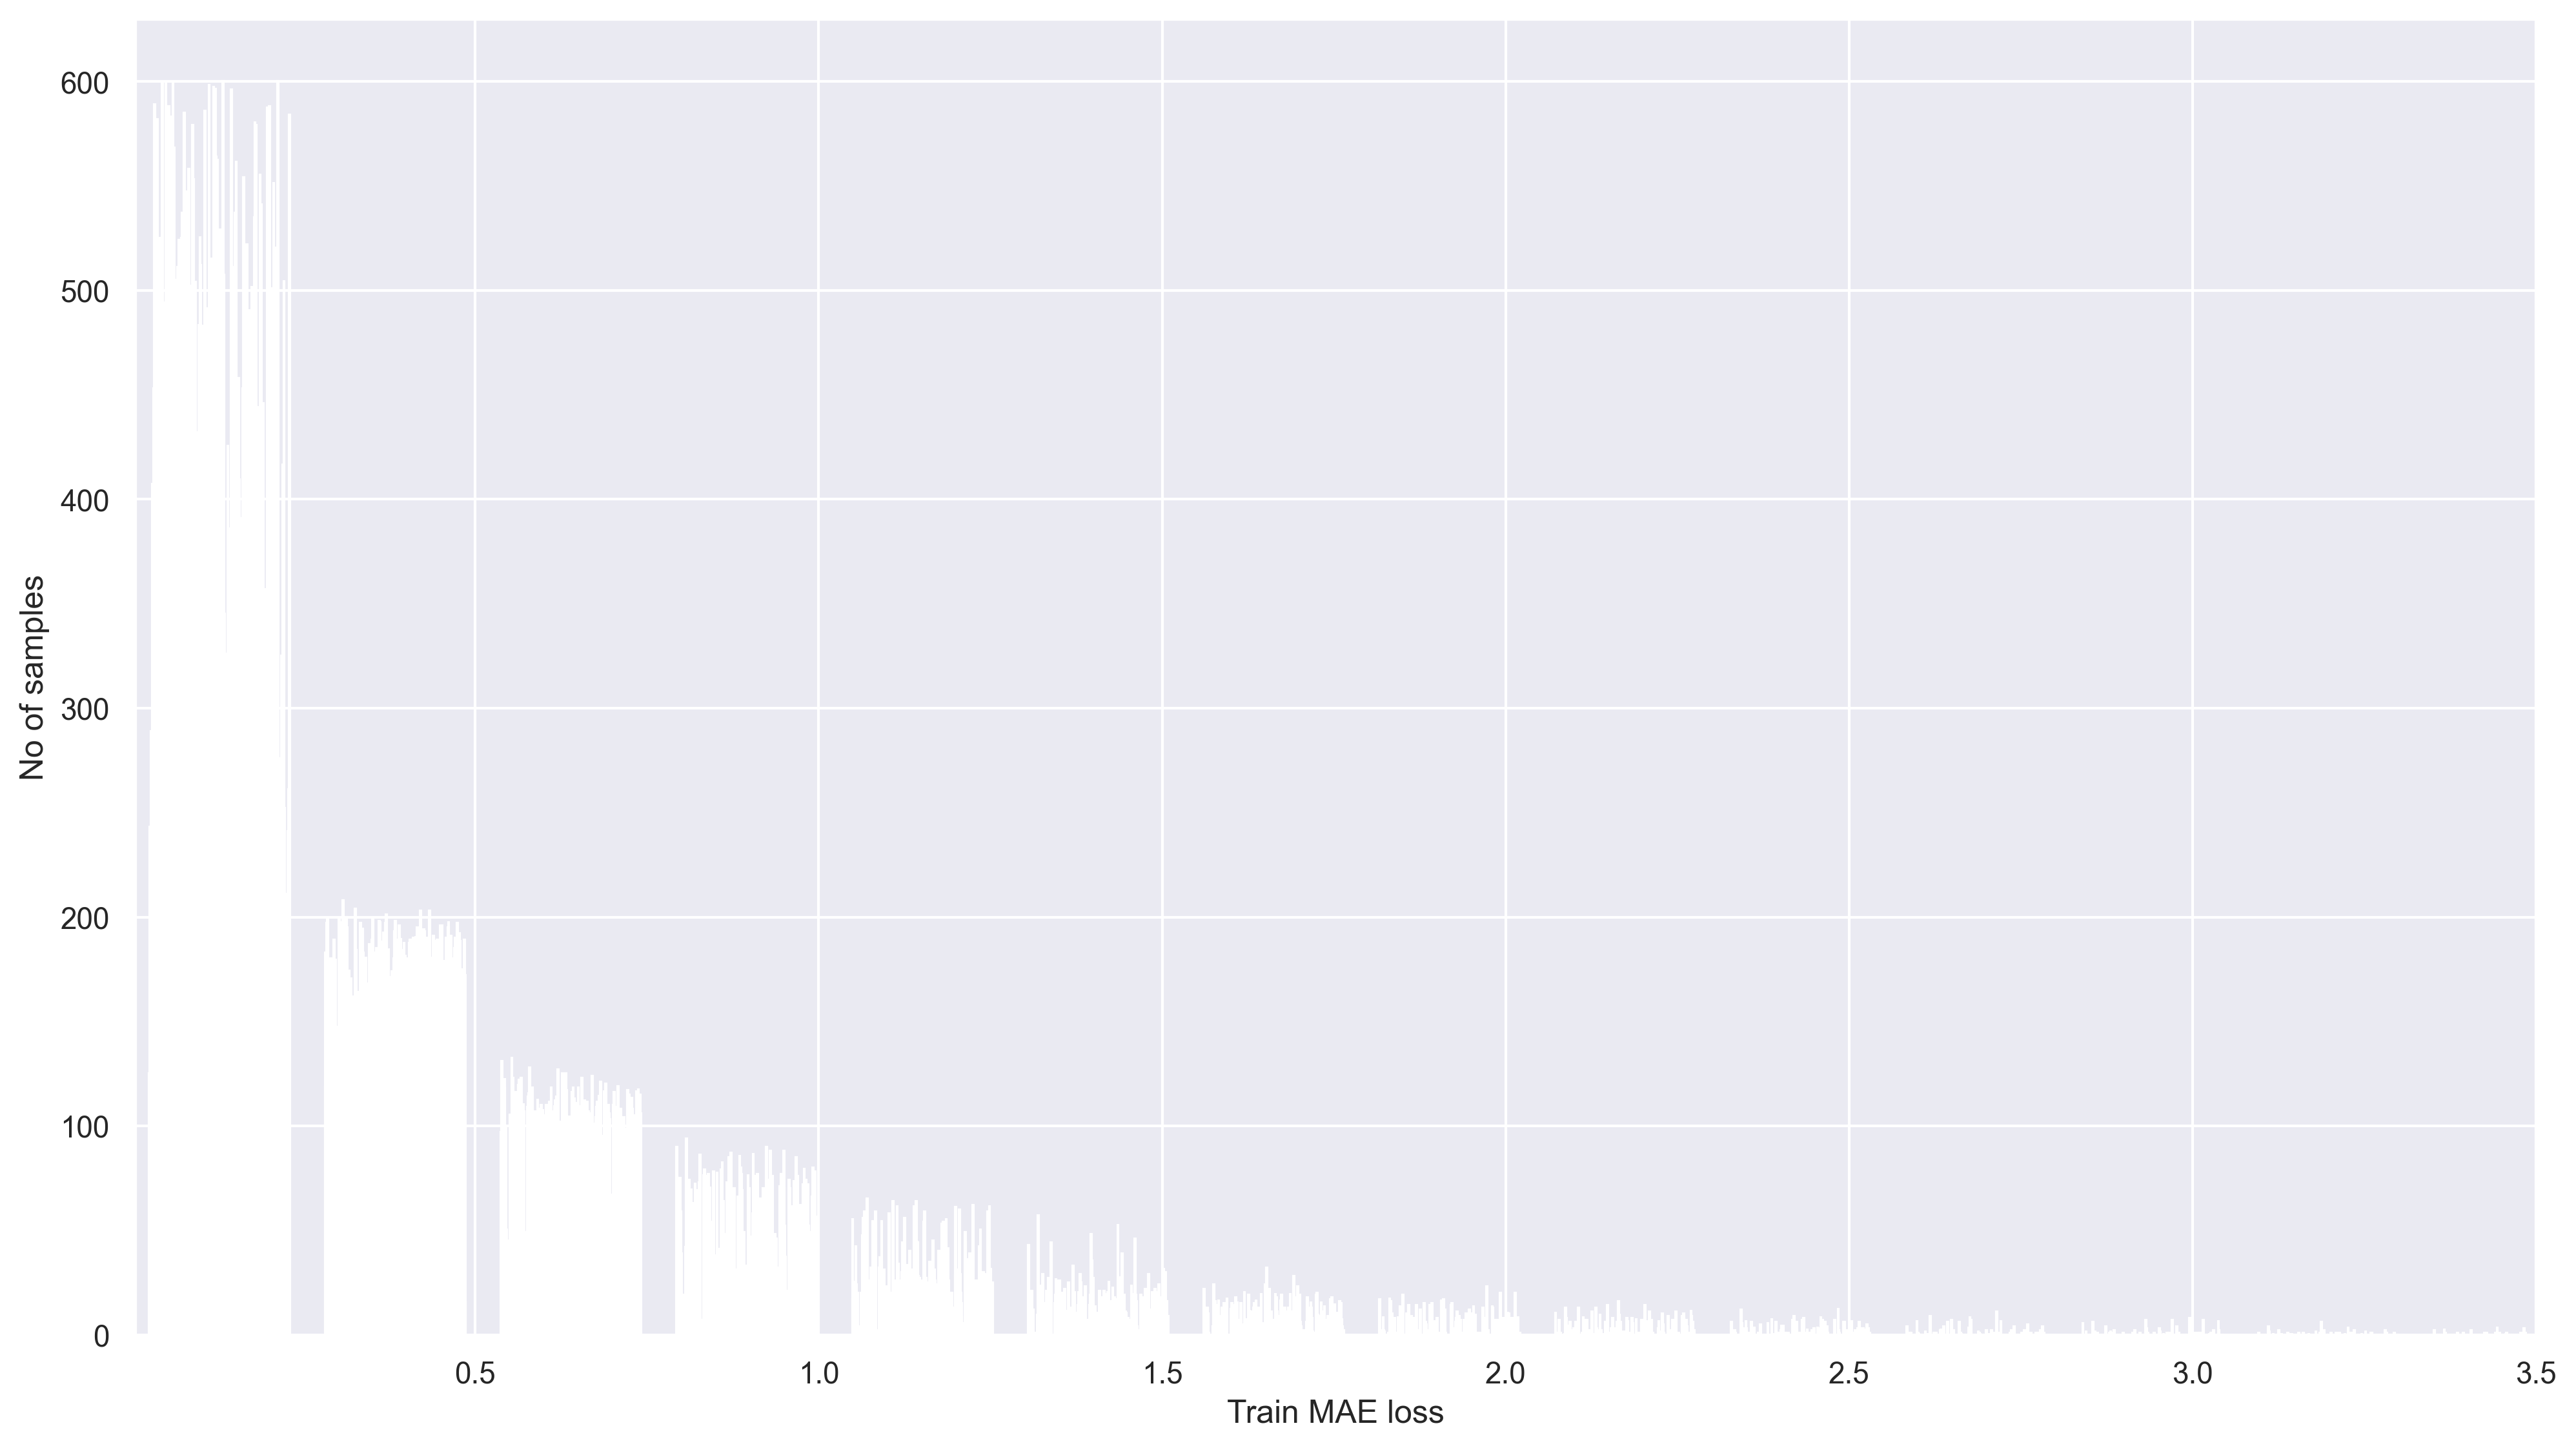

Reconstruction error threshold:  5.116784


In [28]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
plt.figure(figsize=(16,9), dpi= 300)
plt.hist(train_mae_loss, bins= 20)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.xlim([0.005,3.5])
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

## Determinación de threshold con (mean + std)

In [29]:
reconstructions = model.predict(x_train)
train_loss = np.mean(np.abs(reconstructions - x_train), axis=1)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)


Threshold:  0.73824227


## Determinación de Clasificación. (dataset de train)

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, cohen_kappa_score, fbeta_score
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, log_loss
# calculate the loss on the training set
X_pred = model.predict(x_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])    
#X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1])
X_pred = pd.DataFrame(X_pred)

In [32]:
error_df = pd.DataFrame(index=X_pred.index)
Xtrain = x_train.reshape(x_train.shape[0], x_train.shape[2])
error_df['Reconstruction_error'] = np.mean(np.power(X_pred-Xtrain, 2), axis = 1)
error_df['True_class'] = train_dec_a
error_df.head()

,Reconstruction_error,True_class
0,0.453902,0
1,0.015186,0
2,0.006202,0
3,0.775193,0
4,0.205801,0


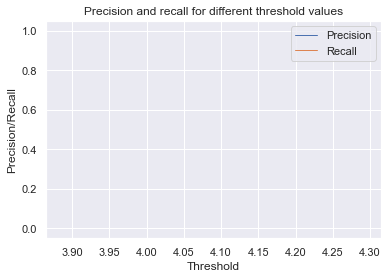

In [33]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=1)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=1)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Text(0.5, 0, 'False Positive Rate')

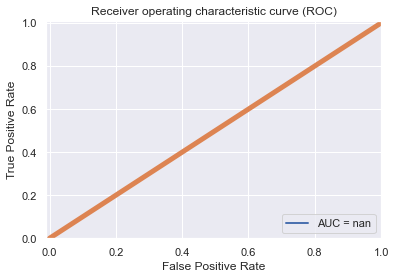

In [34]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

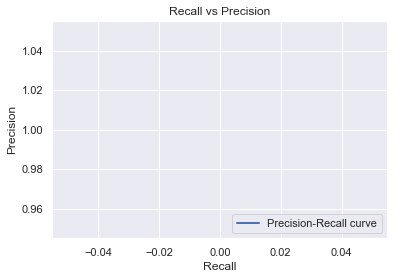

In [35]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=2, label='Precision-Recall curve')
plt.legend(loc='lower right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

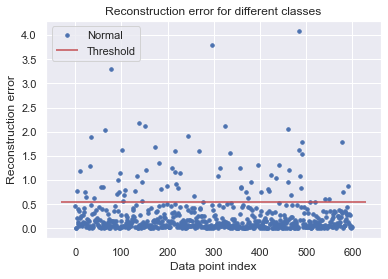

In [36]:
threshold_fixed = 0.55
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "ANOMALY" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

## Confusion Matrix


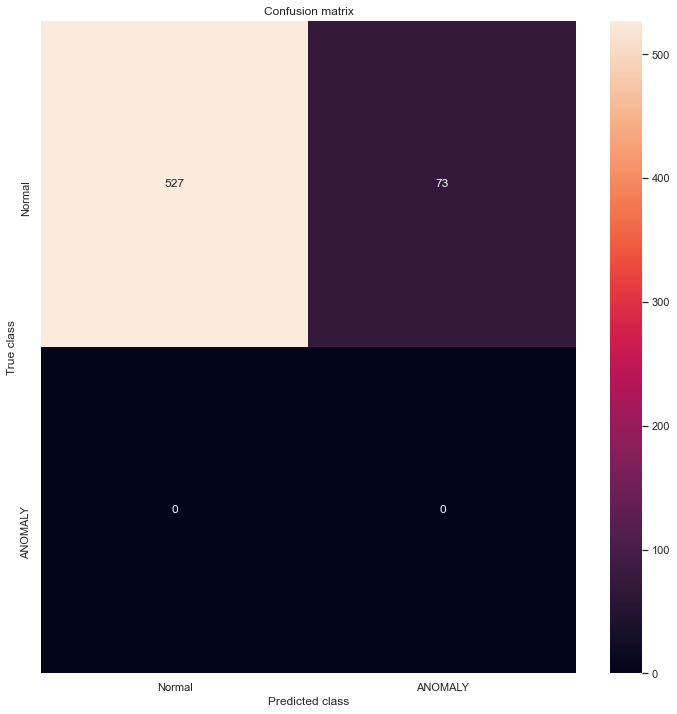

In [37]:
LABELS = ["Normal","ANOMALY"]
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## Reconstruction error - Test set

Text(0.5, 1.0, 'Reconstruction error - Train set')

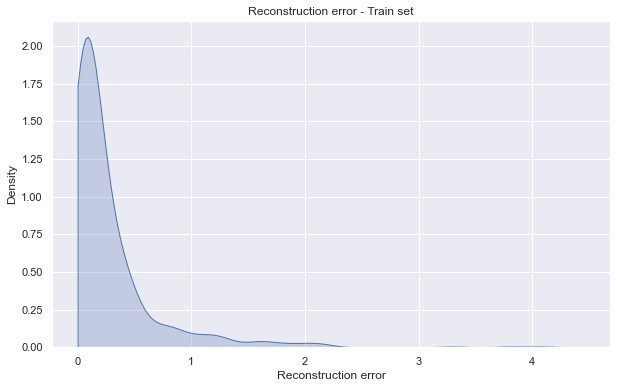

In [38]:
plt.figure(figsize=(10,6))
sns.kdeplot(error_df.Reconstruction_error[error_df.True_class==0], label='Normal', shade=True, clip=(0,10))
sns.kdeplot(error_df.Reconstruction_error[error_df.True_class==1], label='ANOMALY', shade=True, clip=(0,10))
plt.xlabel('Reconstruction error')
plt.title('Reconstruction error - Train set')


## Determinación de Clasificación. Test

In [39]:
# calculate the loss on the test set
X_pred = model.predict(x_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
#X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1])
X_pred = pd.DataFrame(X_pred)


In [40]:
error_df = pd.DataFrame(index=X_pred.index)
Xtest = x_test.reshape(x_test.shape[0], x_test.shape[2])
error_df['Reconstruction_error'] = np.mean(np.power(X_pred-Xtest, 2), axis = 1)
error_df['True_class'] = test_dec_a
error_df.head()

,Reconstruction_error,True_class
0,0.496853,0
1,0.060372,0
2,0.004090,0
3,0.156842,0
4,0.366085,0


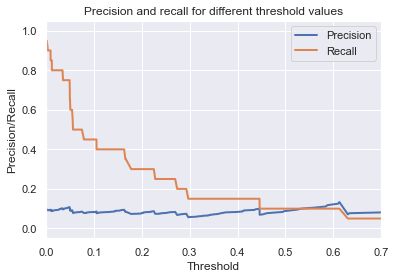

In [41]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=2)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=2)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.xlim([0.0,0.7])
plt.legend()
plt.show()

In [42]:
print(threshold_rt)

[1.31440989e-03 3.52173648e-03 4.09008423e-03 4.67285002e-03
 5.69076557e-03 7.26232771e-03 8.88604578e-03 9.12313256e-03
 9.21074487e-03 9.45787039e-03 9.76612698e-03 1.01148272e-02
 1.05545772e-02 1.12225404e-02 1.17877899e-02 1.18098659e-02
 1.30654415e-02 1.38810398e-02 1.43403756e-02 1.47967096e-02
 1.48752145e-02 1.51503058e-02 1.54328095e-02 1.57752000e-02
 1.69833433e-02 2.18658186e-02 2.31329296e-02 2.38528308e-02
 2.50737444e-02 2.69244760e-02 2.71413922e-02 2.72694137e-02
 2.77382918e-02 2.78783925e-02 2.92234924e-02 2.93609276e-02
 2.93717068e-02 2.97471136e-02 3.18990722e-02 3.28070782e-02
 3.30949388e-02 3.41376364e-02 3.51322889e-02 3.57035585e-02
 3.61743607e-02 3.64990234e-02 3.69173177e-02 3.80468592e-02
 3.83378230e-02 3.87043841e-02 3.92771810e-02 4.15820703e-02
 4.33537215e-02 4.45742086e-02 4.48858403e-02 4.50797155e-02
 4.54165116e-02 4.71009240e-02 4.82192412e-02 4.88773026e-02
 4.93833385e-02 4.94309030e-02 4.98062074e-02 5.04765846e-02
 5.15816174e-02 5.206049

## ROC CURVE CHECK

Text(0.5, 0, 'False Positive Rate')

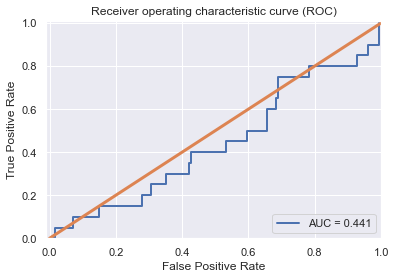

In [43]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=3)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## RECALL VS PRECISION THRESHOLDING

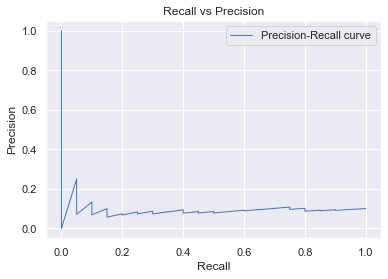

In [44]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=1, label='Precision-Recall curve')
plt.legend(loc='upper right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## Reconstruction Error vs Threshold Check

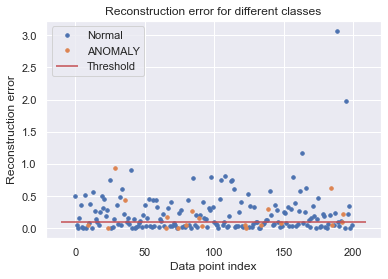

In [51]:
threshold_fixed = 0.1()
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='', label= "ANOMALY" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

## Confusion Matrix

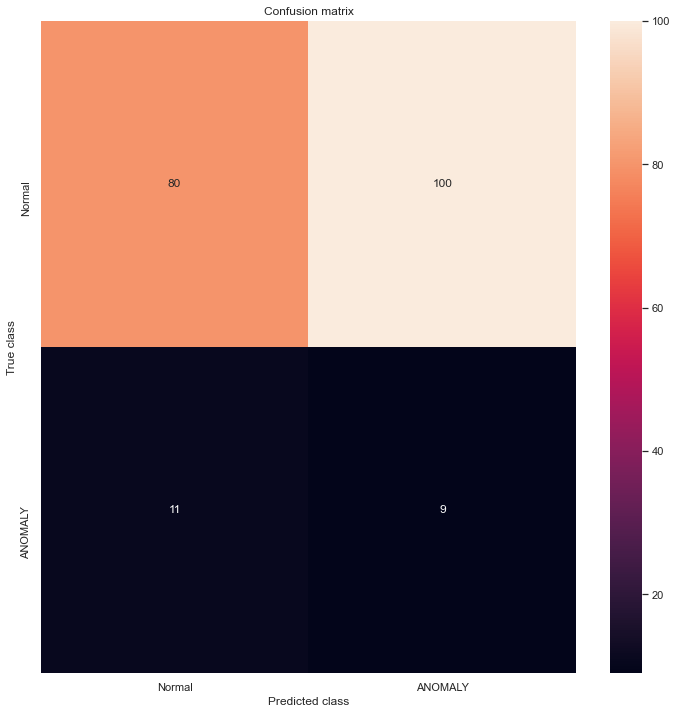

In [52]:
LABELS = ["Normal","ANOMALY"]

pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## MODEL STATS

In [48]:
def print_stats(ytest, ypred):
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, ypred), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    ll = log_loss(ytest, ypred)
    print("Log Loss: {}".format(ll))
    print(' ')
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, ypred))
    print("Classification Report:")
    print(classification_report(ytest, ypred))

In [49]:
print_stats(error_df.True_class, pred_y)

Accuracy: 0.77778, Cohen's Kappa Score: -0.07795
Log Loss: 7.675388640955835
 
Confusion Matrix:
[[153  26]
 [ 18   1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       179
           1       0.04      0.05      0.04        19

    accuracy                           0.78       198
   macro avg       0.47      0.45      0.46       198
weighted avg       0.81      0.78      0.79       198



In [50]:
p = precision_score(error_df.True_class, pred_y)
r = recall_score(error_df.True_class, pred_y)
f = fbeta_score(error_df.True_class, pred_y, beta= 0.5)
print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))

Result: p=0.037, r=0.053, f=0.039


In [64]:
## Modified Classification report -- Vanilla
print("------------------------------------------------------------------------------")
for threshold_fixed in [0.025, 0.045, 0.07, 0.075, 0.08, 0.11]:
    pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.True_class, pred_y)
    #print(conf_matrix)
    p = precision_score(error_df.True_class, pred_y, average='weighted')
    r = recall_score(error_df.True_class, pred_y)
    f = fbeta_score(error_df.True_class, pred_y, beta= 0.5)
    print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))
    print('Threshold fixed=%.3f' % threshold_fixed)
    print_stats(error_df.True_class, pred_y)
    print("------------------------------------------------------------------------------")

------------------------------------------------------------------------------
Result: p=0.831, r=0.895, f=0.118
Threshold fixed=0.025
Accuracy: 0.18687, Cohen's Kappa Score: 0.00138
Log Loss: 28.085202704909193
 
Confusion Matrix:
[[ 20 159]
 [  2  17]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.11      0.20       179
           1       0.10      0.89      0.17        19

    accuracy                           0.19       198
   macro avg       0.50      0.50      0.19       198
weighted avg       0.83      0.19      0.20       198

------------------------------------------------------------------------------
Result: p=0.866, r=0.842, f=0.136
Threshold fixed=0.045
Accuracy: 0.34848, Cohen's Kappa Score: 0.03550
Log Loss: 22.503044970806478
 
Confusion Matrix:
[[ 53 126]
 [  3  16]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.30      0.45       179
        

In [57]:
## RandomSearch/Bayasian/ RS-iterations optimization Keras Tuner
for threshold_fixed in [0.1, 0.15, 0.2, 0.3]:
    pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.True_class, pred_y)
    print(conf_matrix)
    p = precision_score(error_df.True_class, pred_y)
    r = recall_score(error_df.True_class, pred_y)
    f = fbeta_score(error_df.True_class, pred_y, beta= 0.5)
    print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))
    print_stats(error_df.True_class, pred_y)

[[84 95]
 [ 7 12]]
Result: p=0.112, r=0.632, f=0.134
Accuracy: 0.48485, Cohen's Kappa Score: 0.03285
Log Loss: 17.793086636549283
 
Confusion Matrix:
[[84 95]
 [ 7 12]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.47      0.62       179
           1       0.11      0.63      0.19        19

    accuracy                           0.48       198
   macro avg       0.52      0.55      0.41       198
weighted avg       0.85      0.48      0.58       198

[[97 82]
 [11  8]]
Result: p=0.089, r=0.421, f=0.106
Accuracy: 0.53030, Cohen's Kappa Score: -0.01388
Log Loss: 16.22308975614126
 
Confusion Matrix:
[[97 82]
 [11  8]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.54      0.68       179
           1       0.09      0.42      0.15        19

    accuracy                           0.53       198
   macro avg       0.49      0.48      0.41       198
weighted avg     

In [57]:
## Modified LSTM first version
print("------------------------------------------------------------------------------")
for threshold_fixed in [0.025, 0.045, 0.07, 0.075, 0.08, 0.11]:
    pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.True_class, pred_y)
    #print(conf_matrix)
    p = precision_score(error_df.True_class, pred_y, average='weighted')
    r = recall_score(error_df.True_class, pred_y)
    f = fbeta_score(error_df.True_class, pred_y, beta= 0.5)
    print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))
    print('Threshold fixed=%.3f' % threshold_fixed)
    print_stats(error_df.True_class, pred_y)
    print("------------------------------------------------------------------------------")

------------------------------------------------------------------------------
Result: p=0.849, r=0.895, f=0.122
Threshold fixed=0.025
Accuracy: 0.21717, Cohen's Kappa Score: 0.00878
Log Loss: 27.03854888695947
 
Confusion Matrix:
[[ 26 153]
 [  2  17]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.15      0.25       179
           1       0.10      0.89      0.18        19

    accuracy                           0.22       198
   macro avg       0.51      0.52      0.22       198
weighted avg       0.85      0.22      0.24       198

------------------------------------------------------------------------------
Result: p=0.863, r=0.842, f=0.134
Threshold fixed=0.045
Accuracy: 0.33333, Cohen's Kappa Score: 0.03064
Log Loss: 23.026371879781337
 
Confusion Matrix:
[[ 50 129]
 [  3  16]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.28      0.43       179
         

In [52]:
#### Extended LSTM
print("------------------------------------------------------------------------------")
for threshold_fixed in [0.025, 0.045, 0.07, 0.075, 0.08, 0.11]:
    pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.True_class, pred_y)
    #print(conf_matrix)
    p = precision_score(error_df.True_class, pred_y, average='weighted')
    r = recall_score(error_df.True_class, pred_y)
    f = fbeta_score(error_df.True_class, pred_y, beta= 0.5)
    print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))
    print('Threshold fixed=%.3f' % threshold_fixed)
    print_stats(error_df.True_class, pred_y)
    print("------------------------------------------------------------------------------")

------------------------------------------------------------------------------
Result: p=0.875, r=0.947, f=0.125
Threshold fixed=0.025
Accuracy: 0.20202, Cohen's Kappa Score: 0.01505
Log Loss: 27.561879834305195
 
Confusion Matrix:
[[ 22 157]
 [  1  18]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.12      0.22       179
           1       0.10      0.95      0.19        19

    accuracy                           0.20       198
   macro avg       0.53      0.54      0.20       198
weighted avg       0.87      0.20      0.21       198

------------------------------------------------------------------------------
Result: p=0.833, r=0.789, f=0.119
Threshold fixed=0.045
Accuracy: 0.28283, Cohen's Kappa Score: 0.00446
Log Loss: 24.770790871326682
 
Confusion Matrix:
[[ 41 138]
 [  4  15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.23      0.37       179
        

## Results 
1. Original LSTM:
    78 - 12
    90 - 11
    102 - 10
    138 - 9
    148 - 8
    151 - 7

2. Extended LSTM:
    65 - 12
    90 - 11
    115 - 10
    146 - 9
    147 - 8
    147 - 7

3. Extended LSTM con mas regularizers y dropout:
    87 - 13
    88 - 12
    89 - 11
    96 - 10
    109 - 9
    110 - 8
    112 - 7
    124 - 6
    

3. Vanilla Model:
    88 - 12
    88 - 11
    99 - 10
    99 - 9
    104 - 8
    105 - 7

## Segundo modelo -- capas Dense (redes NN)

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
#Capa input
model.add(layers.Input(shape=(x_train.shape[1],x_train.shape[2])))
#Capas ocultas
model.add(layers.Dense(64, activation = "relu"))
model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
model.add(layers.Dense(32, activation = "relu"))
model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
model.add(layers.Dense(64, activation = "relu"))
model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
#Capa salida
model.add(layers.Dense(x_train.shape[2], activation = "sigmoid"))
model.summary()

In [ ]:
model.compile(
 optimizer = "adam",
 loss = "mae",
 metrics = ['mae', 'mse']
)

In [ ]:
history = model.fit(
 x_train, x_train,
 epochs= 50,
 batch_size = 32,
 validation_split= 0.1,
)
print("Validation loss:", np.mean(results.history["val_loss"]))

In [ ]:
etrain = DataFrame()
etrain['B'] = history.history['loss']
print(etrain.describe())
etrain.boxplot()
plt.show()

In [ ]:
print("Best MAE on Validation Set =", max(history.history['val_mae']))

In [ ]:
loss = model.evaluate(x_test, x_test, verbose=0)
print(loss)

In [ ]:
for name, value in zip(model.metrics_names, loss):
    print(name, value)

## Tercer modelo -- Variational Autoencoder

In [ ]:
## VAE -- utilizando resampling del espacio latente
import keras
from keras import layers,models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1DTranspose, Input
from keras import backend as BE


original_dim = 200
intermediate_dim = 20
latent_dim = 15 

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [ ]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = BE.random_normal(shape=(BE.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + BE.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [ ]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - BE.square(z_mean) - BE.exp(z_log_sigma)
kl_loss = BE.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = BE.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [ ]:
history = vae.fit(x_train, x_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(x_test, x_test))

In [ ]:
import matplotlib.pyplot as plt


history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
## Creamos el plot para mostrar el loss y val_loss durante los epochs

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [ ]:
"""
import keras
from keras import layers,models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1DTranspose, Input

model = keras.Sequential([
    layers.Input(shape=(x_train.shape[0],x_train.shape[1])),
    layers.Conv1D( 32, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Dropout(rate=0.2),
    layers.Conv1D( 16, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Conv1DTranspose( 16, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Dropout(rate=0.2),
    layers.Conv1DTranspose( 32, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Conv1DTranspose(1, 7, padding="same"),
])
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = "mse")
model.summary()
"""

In [ ]:
"""
history = model.fit(
    x_train,
    x_train,
    epochs = 50,
    batch_size = 32,
    validation_split = 0.1,
    callbacks = [ 
        keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, mode="min")
    ]
)
"""